# Section 3: Real QPU via Amazon Braket (Rigetti)
- In this section we simulates the quantum evolution of a simplified 1D Burgers’ Equation on Real QPU via Amazon Braket (Rigetti).

In [1]:
# !pip install boto3 amazon-braket-sdk pennylane amazon-braket-pennylane-plugin

In [2]:
import pennylane as qml
from braket.aws import AwsDevice

devices = AwsDevice.get_devices()
for d in devices:
    print(d.name, "-", d.status)

Ankaa-3 - ONLINE
Aquila - ONLINE
Aria 1 - ONLINE
Aria 2 - OFFLINE
Emerald - ONLINE
Forte 1 - OFFLINE
Forte Enterprise 1 - OFFLINE
Garnet - ONLINE
SV1 - ONLINE
TN1 - ONLINE
dm1 - ONLINE


In [3]:
from braket.aws import AwsSession
from braket.aws import AwsDevice

# Set session with specific region
session = AwsSession()
devices = AwsDevice.get_devices(provider_names=["Rigetti"], aws_session=session)

for d in devices:
    print(d.name, "-", d.arn, "-", d.status)

Ankaa-3 - arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3 - ONLINE


In [4]:
import boto3
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as pnp

In [7]:
# Setting my S3 bucket and Rigetti device
s3_bucket = "amazon-braket-rigetti-sajib"
s3_folder = "rigetti-results/"

#### Load the Rigetti QPU

In [8]:
rigetti_device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")

#### Set up PennyLane device with Braket backend

In [9]:
dev_rigetti = qml.device("braket.aws.qubit", 
                 device_arn=rigetti_device.arn, 
                 wires=2,  # or 4, depending on how many qubits we used
                 s3_destination_folder=("amazon-braket-rigetti-sajib", "rigetti-results/"), shots=1000)

- we must measure the circuit multiple times (called shots) to estimate probabilities. Here, we took shots=1000 to run the same circuit 1000 times and collect the final measurement outcomes.

## QTN- 2 Qubits (4 Grid Points)

#### Set hyperparameters

In [10]:
n_qubits = 2               # start with 2 qubits = 4 grid points
grid_size = 2 ** n_qubits  # Total spatial resolution
nu = 0.01                  # Viscosity
dt = 0.1                   # Time step size
n_steps = 20               # Total number of Time steps 

#### Initial condition - step function

In [11]:
def initial_condition(grid_size):
    x = np.linspace(0, 1, grid_size) # x is the spatial coordinate
    u0 = np.where(x < 0.5, 1.0, 0.0) 
    norm = np.linalg.norm(u0)
    return u0 / norm

u0 = initial_condition(grid_size) 

#### Define the QTN-based circuit

In [12]:
def trotter_layer(params, t):# params: Trainable parameters that are time-evolving angles
    @qml.qnode(dev_rigetti)
    def trotter():
        # Apply Trotterized layer for time t
        for i in range(n_qubits - 1):
            qml.CRX(2 * dt * params[i], wires=[i, i+1]) # CRX: simulates diffusion between neighbors i.e. interaction term
        for i in range(n_qubits):
            qml.RY(-dt * params[-1], wires=i)    # RY: models local nonlinear convective term i.e. rotates individual grid points

In [13]:
def qtn_circuit_rigetti(params, steps=n_steps):
    @qml.qnode(dev_rigetti)
    def circuit():
        qml.MottonenStatePreparation(u0, wires=range(n_qubits))
        for t in range(steps):
            trotter_layer(params, t)
        return qml.probs(wires=range(n_qubits)) 
    return circuit()  # call the inner circuit

#### Define Params

In [14]:
params = pnp.array(np.random.uniform(0, np.pi, size=(n_qubits,)), requires_grad=True)

## Run the circuit on Rigetti QPU

In [15]:
print("Submitting job to IonQ QPU...")
final_probs_qpu = qtn_circuit_rigetti(params)

Submitting job to IonQ QPU...


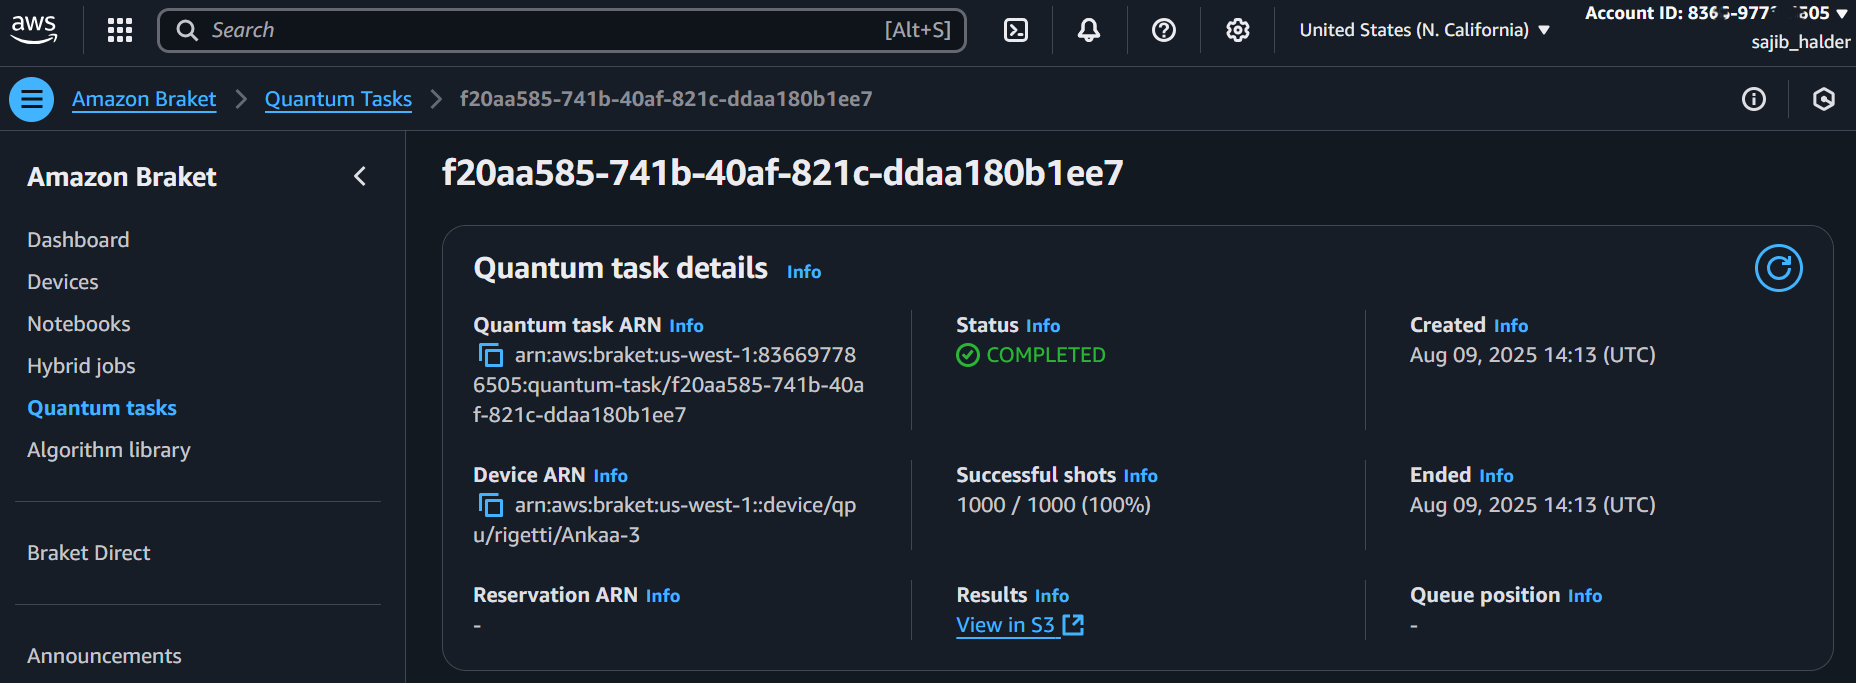

#### Target: simple diffused distribution

In [16]:
target = np.linspace(1.0, 0.0, grid_size)    # A linearly decreasing velocity field across space
target = target / np.linalg.norm(target)     # Normalized to match quantum state's unit norm constraint

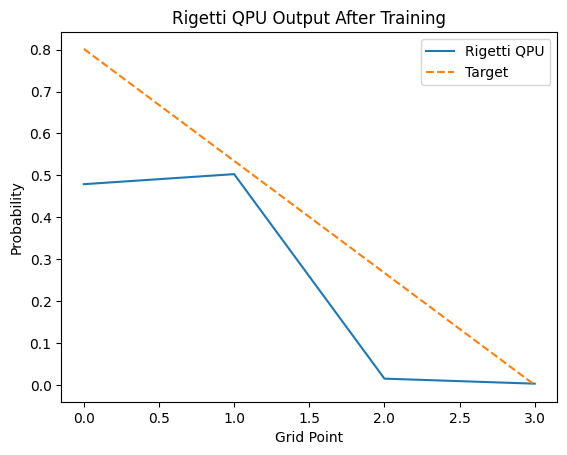

In [17]:
import matplotlib.pyplot as plt
plt.plot(final_probs_qpu, label='Rigetti QPU')
plt.plot(target, '--', label='Target')
plt.title("Rigetti QPU Output After Training")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Run the circuit on our local System 

In [19]:
dev = qml.device("default.qubit", wires=n_qubits) # Set up the local Quantum Device

def trotter_layer(params, t):                       # params: Trainable parameters that are time-evolving angles
    # Apply Trotterized layer for time t
    for i in range(n_qubits - 1):
        qml.CRX(2 * dt * params[i], wires=[i, i+1]) # CRX: simulates diffusion between neighbors i.e. interaction term
    for i in range(n_qubits):
        qml.RY(-dt * params[-1], wires=i)    # RY: models local nonlinear convective term i.e. rotates individual grid points
        
@qml.qnode(dev)
def qtn_circuit(params, steps=n_steps):
    qml.MottonenStatePreparation(u0, wires=range(n_qubits)) #prepares the initial condition u0 as a quantum state on our qubits.
    for t in range(steps):
        trotter_layer(params, t)
    return qml.probs(wires=range(n_qubits))


params = pnp.array(np.random.uniform(0, np.pi, size=(n_qubits,)), requires_grad=True)

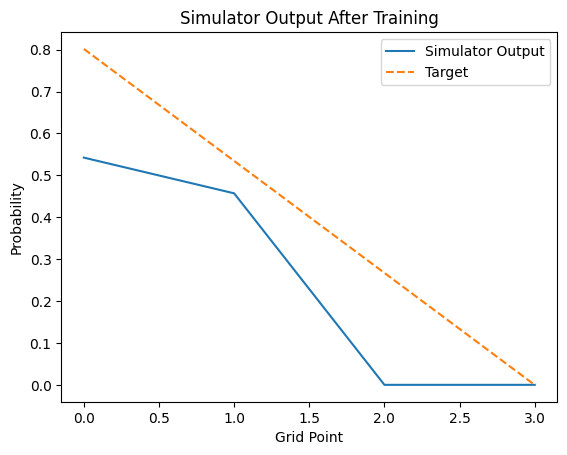

In [20]:
final_probs_sim = qtn_circuit(params)

plt.plot(final_probs_sim, label='Simulator Output')
plt.plot(target, '--', label='Target')
plt.title("Simulator Output After Training")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

#### Comparison between local system vs Amazon Rigetti

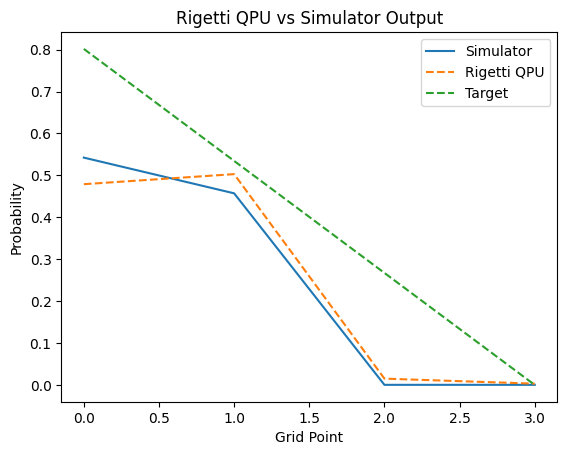

In [21]:
plt.plot(final_probs_sim, label='Simulator')
plt.plot(final_probs_qpu, label='Rigetti QPU', linestyle='--')
plt.plot(target, '--', label='Target')
plt.title("Rigetti QPU vs Simulator Output")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

#### Getting Raw Probabilty from QPU

In [4]:
import boto3, json
import numpy as np
from collections import Counter

bucket = "amazon-braket-rigetti-sajib"
key = "rigetti-results//f20aa585-741b-40af-821c-ddaa180b1ee7/results.json"

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=key)
data = json.loads(obj["Body"].read().decode("utf-8"))

# As Rigetti results often have "measurements" as a list of shots
if "measurements" in data:
    shots_list = data["measurements"]
    # Convert each shot to bitstring
    bitstrings = ["".join(str(bit) for bit in shot) for shot in shots_list]
    counts = dict(Counter(bitstrings))
else:
    counts = data["measurementCounts"]

print("Raw counts:", counts)


# Convert counts to probabilities
total_shots = sum(counts.values())
probs = {state: c / total_shots for state, c in counts.items()}
print("Raw probabilities:", probs)

Raw counts: {'01': 503, '00': 479, '10': 15, '11': 3}
Raw probabilities: {'01': 0.503, '00': 0.479, '10': 0.015, '11': 0.003}


### Error Mitigation by ZNE (Zero-Noise Extrapolation)

- As quantum computers make mistakes because of noise, ZNE error mitigation can resolve this. But, ZNE doesn’t remove noise physically - instead, it estimates what the result would have been if there was no noise.
- For this we run the same circuit at different noise levels (scale factors like 1x, 3x, 5x noise). Usually done by gate folding that is inserting extra gates that don’t change the ideal result but make the circuit noisier.
- Then measure the result for each noise scale and then fit a curve (like a line) through the noisy results and extrapolate back to “zero noise” (scale = 0).